# Block channels

In [1]:
# simulation script
from __future__ import print_function, division
from neuron import h
from joblib import Parallel, delayed
import multiprocessing
import numpy                as np
import matplotlib.pyplot    as plt
import plot_functions       as fun
import MSN_builder          as build
import glob
import pickle
import sys
import os.path 



h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')


# D1
D1_params  =   [[0.5739438400147591, 114.46525970607432, -24.778683242914425, 0.9656307062939439, 40.55882910975278, 4.924556428134727],    \
                [0.6486015000884895, 37.19526177848555, -51.44257878295532, 0.9199040036041007, 38.773590273202544, 4.138269856798566],     \
                [0.34835213066115794, 92.06973911679478, -13.043854781662562, 0.9812668369096036, 35.31855413027535, 4.764644405812756],    \
                [0.8115471666044635, 44.7944466983775, -51.05269981676671, 0.9310487434283193, 40.02623282398899, 3.698685454575806],       \
                [0.5009368290963206, 26.47283142378077, -40.15544309999925, 0.9376314551458907, 34.918864668708565, 5.689649054327928],     \
                [0.11337316688781601, 74.85203079871395, -37.663738588683266, 0.9791107718457724, 40.313411748972555, 1.7599610703626931],  \
                [0.7178317755261724, 55.78999694946826, -40.594540879418844, 0.934360843812911, 24.039770691171, 11.85002736955439],        \
                [0.7084541798016345, 60.5127880861534, -55.54871428461576, 0.9063982542677244, 44.50455979565052, 1.2727982786963663],      \
                [0.6035708031273619, 46.80870702319583, -64.09248569745006, 0.9280326409654382, 37.58186874484719, 2.729291505716056],      \
                [0.561072695250727, 30.279814655445957, -5.915582850103075, 0.9240749040725246, 47.175148898308336, 3.9786457316868438],    \
                [0.7084541798016345, 60.5127880861534, -55.54871428461576, 0.9063982542677244, 44.50455979565052, 1.2727982786963663] ]

# D2
D2_params  =   [[0.36519026711426983, 85.9950693571762, -29.308683882971575, 0.9148525825598594, 31.715617529156468, 14.265211741761483],   \
                [0.16856005736302448, 126.23264636214776, -24.844746770683354, 0.9321044414025511, 30.258105136928478, 16.71932312947103],  \
                [0.8998189135933885, 119.36936307317013, -46.95178922978055, 0.8971817650810714, 33.820535805627614, 13.259594919674436],   \
                [0.3212471483859052, 73.2110386772533, -21.537721797784236, 0.9086172801642267, 36.981483525375666, 10.22848048793786],     \
                [0.5820977302857862, 57.946759035757786, -18.187141446438467, 0.8928497341805598, 46.779147877476554, 11.121000433080683],  \
                [0.46297432359551316, 54.020547269954754, -41.038717738089424, 0.9112928426829239, 23.74013590665613, 21.09496685904177],   \
                [0.20862895117356128, 14.373675087979382, -69.54059375795693, 0.9336951592433631, 43.40456122099932, 15.291555103979722],   \
                [0.42405610469134825, 2.083973089688305, -64.58731908139677, 0.9006809103056398, 31.54569527007518, 11.894971817963789],    \
                [0.2935952963686902, 84.25383011698389, -43.048666783931345, 0.9299719258473008, 42.89522927693975, 14.821301506581849],    \
                [0.813828871477326, 84.51778812354367, -22.93434820961655, 0.9024356980563085, 36.356176317731936, 16.866648293828433] ]


D1_rheobase =   [360, 400, 360, 420, 400, 320, 420, 400, 400, 400, 400]    
D2_rheobase =   [220, 200, 220, 220, 220, 220, 200, 220, 200, 240]



def save_vector(t, v, outfile):
    
    with open(outfile, "w") as out:
        for time, y in zip(t, v):
            out.write("%g %g\n" % (time, y))                     
 
                  
# 'save/'+ 
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        
def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)
    
    
def configure_plot_window(ax):
    '''
    configure plot window
    '''
    
    for aca in ax:
        # Hide the right and top spines
        aca.spines['right'].set_visible(False)
        aca.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        aca.yaxis.set_ticks_position('left')
        aca.xaxis.set_ticks_position('bottom')


        # set ticks
        yticks = [0,1]
        aca.set_yticks(yticks)
        aca.set_yticklabels(yticks, fontsize=35)
        xticks = [40, 120, 200]
        aca.set_xticks(xticks)
        aca.set_xticklabels(xticks, fontsize=35)
        aca.set_xlim([0,300])
        aca.set_ylim([0,1.1])

        aca.tick_params(width=2, length=4)

        # size of frame
        for axis in ['bottom','left']:
            aca.spines[axis].set_linewidth(4)
        




def main(       par='./params_iMSN.json',               \
                morphology='WT-P270-09-14ak_iMSN.swc',  \
                sim='vm',                               \
                amp=0.40,                               \
                lim='40-60',                            \
                run=None,                               \
                cell_type='D1',                         \
                block=None,                             \
                distParams=None,                        \
                simDur=1000,                            \
                stimDur=900         ): 
    
    
    if run == 0:
        print('-amp:', amp, '[nA]', 'block', block,  \
              '-type', cell_type, '-sim', sim)
    
    
    if distParams:
        # load best fit parameters
        random_variables = distParams
    else:
        # draw random parameters
        random_variables = [    np.random.uniform(0.1,0.9), \
                                np.random.uniform(1,130),   \
                                np.random.uniform(-3,-70),  \
                                np.random.uniform(0.0,1.0), \
                                np.random.uniform(20,50),   \
                                np.random.uniform(1,50)     ]
        
        
    # initiate cell
    cell = build.MSN(  params=par,                  \
                       morphology=morphology,       \
                       variables=random_variables   )
    
    
    # set cascade--not connected to channels in this script, 
    # but used for setting pointers needed in the channel mechnisms
    casc    =   h.D1_reduced_cascade2_0(0.5, sec=cell.soma) 
    pointer =   casc._ref_Target1p    
       
    
    # set edge of soma as reference for dendritic distance 
    h.distance(1, sec=h.soma[0])
    
    
    # set current injection
    stim        =   h.IClamp(0.5, sec=cell.soma)
    stim.amp    =   amp  
    stim.delay  =   100
    stim.dur    =   stimDur    
     
    
    tstop       = simDur 
    # dt = default value; 0.025 ms (25 us)
                  
    
    # set pointers; need since same mechanisms are used for dynamic modulation of channels.
    # Modulation of channels is not used in this script
    # -also block channels
    for sec in h.allsec():
        
        for seg in sec:
            
            
            # naf and kas is in all sections
            h.setpointer(pointer, 'pka', seg.kas )
            h.setpointer(pointer, 'pka', seg.naf )
            
            if sec.name().find('axon') < 0:    
                
                
                # these channels are not in the axon section
                h.setpointer(pointer, 'pka', seg.kaf )
                h.setpointer(pointer, 'pka', seg.cal12 )
                h.setpointer(pointer, 'pka', seg.cal13 )
                h.setpointer(pointer, 'pka', seg.kir )
                
                if sec.name().find('soma') >= 0:
                    
                    
                    # N-type Ca (can) is only distributed to the soma section
                    h.setpointer(pointer, 'pka', seg.can )
            
    if sim == 'vm':
        # record vectors
        tm  = h.Vector()
        tm.record(h._ref_t)
        vm  = h.Vector()
        vm.record(cell.soma(0.5)._ref_v)
        
        # block channel:
        if block != 'control':

            for sec in h.allsec():
                for seg in sec: 
                    for mech in seg:

                        if mech.name() == block:

                            mech.gbar = 0
                            
    elif sim=='ca':
        
        if run == 0:
            # record vectors
            tm  = h.Vector()
            tm.record(h._ref_t)
        
        # configure simulation to record from both calcium pools.
        # the concentration is here summed, instead of averaged. 
        # This doesn't matter for the relative concentrations used 
        # (same size Ca pools gives factor 2)
        for i,sec in enumerate(h.allsec()):

            for j,seg in enumerate(sec):


                # uncomment here if testing kaf blocking effect on bAP
                if block == 'kas':

                    # blocking kas (100%)
                    seg.kas.gbar   = 0

                elif block == 'naf': # and sec.name().find('the right section') >= 0:

                    # block naf (100%) for all segments within lim (def 40-60 mu from soma) 
                    dist    = h.distance(seg.x, sec=sec)
                    limits  = lim.split('-')
                    if dist > int(limits[0]) and dist < int(limits[1]):
                        seg.naf.gbar   = 0


                if sec.name().find('axon') < 0: # don't record in axon

                    if block == 'kaf':

                        # blocking kaf (50% ?), kaf is not distributed to the axon
                        block_fraction = 0.999
                        gbar           = seg.kaf.gbar
                        seg.kaf.gbar   = (1 - block_fraction) * gbar

                    sName = sec.name().split('[')[0]


                    # N, P/Q, R Ca pool
                    cmd = 'ca_%s%s_%s = h.Vector()' % (sName, str(i), str(j))
                    exec(cmd)
                    cmd = 'ca_%s%s_%s.record(seg._ref_cai)' % (sName, str(i), str(j))
                    exec(cmd)   

                    # the L-type Ca
                    cmd = 'cal_%s%s_%s = h.Vector()' % (sName, str(i), str(j))
                    exec(cmd)
                    cmd = 'cal_%s%s_%s.record(seg._ref_cali)' % (sName, str(i), str(j))
                    exec(cmd)   
                
                
              
    # solver------------------------------------------------------------------------------            
    cvode = h.CVode()
    
    h.finitialize(cell.v_init)
    
    # run simulation
    while h.t < tstop:
                
        h.fadvance()
        
    
    if sim == 'vm':
    
        # return vectors             
        return [tm, vm]  
    
    elif sim == 'ca':
        
        res        = {}
        transients = {}
        

        if cell_type == 'D1':
            distances   = np.arange(40,200, 10)
        else:
            distances   = np.arange(49,200, 10)


        # for all sec
        for i,sec in enumerate(h.allsec()):
            # skip axon
            if sec.name().find('axon') < 0:
                # for all seg in sec
                for j,seg in enumerate(sec):

                    dist    =    int( np.round( h.distance(seg.x) ) ) 
                    
                    # if dist is out of range
                    if dist <= (distances[0]  - 5) or \
                       dist >= (distances[-1] + 5):
                            
                            continue
                            
                    # calc index (k) and get distance key (d) 
                    x       =    (dist - distances[0])/10.0
                    k       =    int(round(x))
                    d       =    distances[k]
                    
                    # save to result dict
                    if d not in res:
                        res[d] = []

                    vName   =   'ca_%s%s_%s'  %  ( sName, str(i), str(j)  )
                    v2Name  =   'cal_%s%s_%s' %  ( sName, str(i), str(j)  )
                    cmd     =   'V = np.add(%s, %s)' % (vName, v2Name) # this is were concentrations are summed (see above ~line 140)
                    exec(cmd)
                    dCa     =   max(V[3300:-1]) - V[3300]
                    res[d].append(dCa)
                    
                    # save transient if dist within 50 +/- 5 from soma
                    if np.abs(dist-50) < 5:
                        name             =  sec.name().split('[')[1].split(']')[0]
                        transients[name] =  V
                    
        
        # calc mean and return list as function of distance
        y       = []
        norm    = np.mean(res[distances[0]])
        
        for d in distances:
            y.append( np.divide(np.mean(res[d]), norm) )
            
        
        # return vector             
        return [y, res, transients]    
     
    
           
    

In [14]:


def start_simulation(ct, sim='vm', block=['control'], add=0, axes=None, lim=''):
    # Start the simulation
    
    if axes is None:
        fig, ax     = plt.subplots(3,3, figsize=(16, 12) )
    else:
        ax          = axes
        
    
    num_cores       = multiprocessing.cpu_count()
    colors          = ['k', 'g', 'b', 'm', 'grey'] 
    chan2block      = ['control', 'sk', 'kas', 'kaf', 'naf']
    
    
    
    if ct == 1:
        cell_type   =   'D1'
        par         =   './params_dMSN.json'
        morphology  =   'latest_WT-P270-20-14ak.swc'
        parameters  =   D1_params
        rheo        =   D1_rheobase
        distances   =   np.arange(40,200, 10)

    elif ct == 2:
        cell_type   =   'D2'
        par         =   './params_iMSN.json'
        morphology  =   'WT-P270-09-14ak_iMSN.swc'
        parameters  =   D2_params
        rheo        =   D2_rheobase
        distances   =   np.arange(49,200, 10)
    
    
    
    if sim=='vm':
        simDur      =   1000
        stimDur     =   900

    elif sim=='ca':
        simDur      =   200
        stimDur     =   2
        rheo        =   [2000] * len(rheo)
    
    
    for b in block:
        
        file_name   =   'Results/' + sim + '_block_' + cell_type + '_' + b + lim

        if os.path.isfile(''.join([file_name, '.pkl']) ):

            M = load_obj(file_name + '.pkl')
        
        else:
            
            M = Parallel(n_jobs=num_cores)(delayed(main)(par=par,   \
                                        morphology=morphology,      \
                                        run=run,                    \
                                        amp=(rheo[run]+add)*1e-3,   \
                                        simDur=simDur,              \
                                        stimDur=stimDur,            \
                                        sim=sim,                    \
                                        cell_type=cell_type,        \
                                        block=b,                    \
                                        lim=lim,                    \
                                        distParams=p                \
                ) for run,p in enumerate(parameters[0:num_cores])   )

            #save voltage traces
            save_obj(M, file_name)
            
            
            
        color = colors[chan2block.index(b)]
        
        # if 'naf' block
        if b == 'naf' and len(block) == 1:
            # compare to control

            # load control
            c_name   =   'Results/' + sim + '_block_' + cell_type + '_' + 'control'
            c_M      =   load_obj(c_name + '.pkl')
        
        for i,m in enumerate(M):
            
            if sim=='vm':

                a1 = int(np.floor(i/3))
                a2 = i%3

                ax[a1,a2].plot(m[0], m[1], color=color, lw=2)
                
            
            elif sim=='ca':
                
                if i==0:
                    label=b
                else:
                    label=''

                if color=='k':
                    a=1
                else:
                    a=0.4
                
                # if 'naf' block
                if b == 'naf' and len(block) == 1:
                    
                    # extract peak data (control and naf)
                    peak_control = c_M[i][1]
                    peak_naf     = m[1]
                    median       = []
                    
                    # loop over calc median percentage of peaks(dist)
                    for j,d in enumerate(distances):
                        ratio   = np.divide  ( peak_naf[d], peak_control[d] )
                        percent = np.multiply( ratio,       100             )
                        median.append(np.mean(percent))
                        
                        ax[1].plot( [j]*len(peak_naf[d]), peak_naf[d],     'ko', ms=20, alpha=0.5 )
                        ax[1].plot( [j]*len(peak_naf[d]), peak_control[d], 'ro', ms=10, alpha=0.5 )
                    
                    # plot
                    ax[0].plot( distances, median, '-o', color='r')
                    ax[0].set_ylim([-2, 102])
                    ax[0].set_ylim(ax[0].get_ylim()[::-1])
                    
                else:
                    ax.plot( distances, m[0],           \
                                        color=color,    \
                                        alpha=a,        \
                                        lw=2,           \
                                        label=label     )
                    ax.set_title(cell_type, fontsize=30)
                
                
                    
                    
    if axes is None:
        plt.show()
    elif not 'naf' in block:
        ax.legend(loc='best')

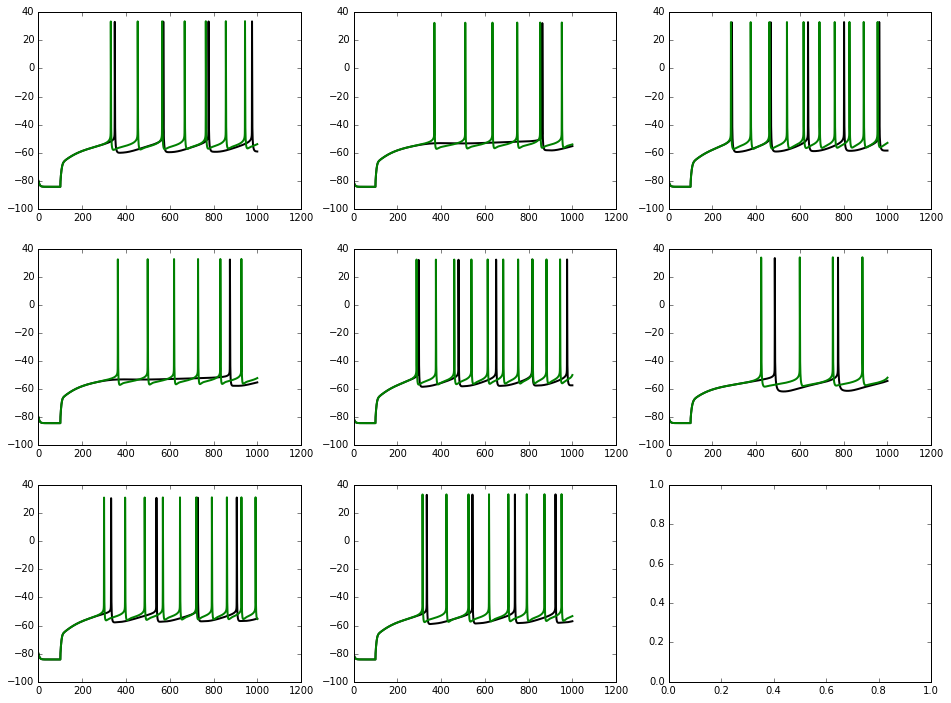

In [3]:
start_simulation(1, block=['control', 'sk'], add=0)

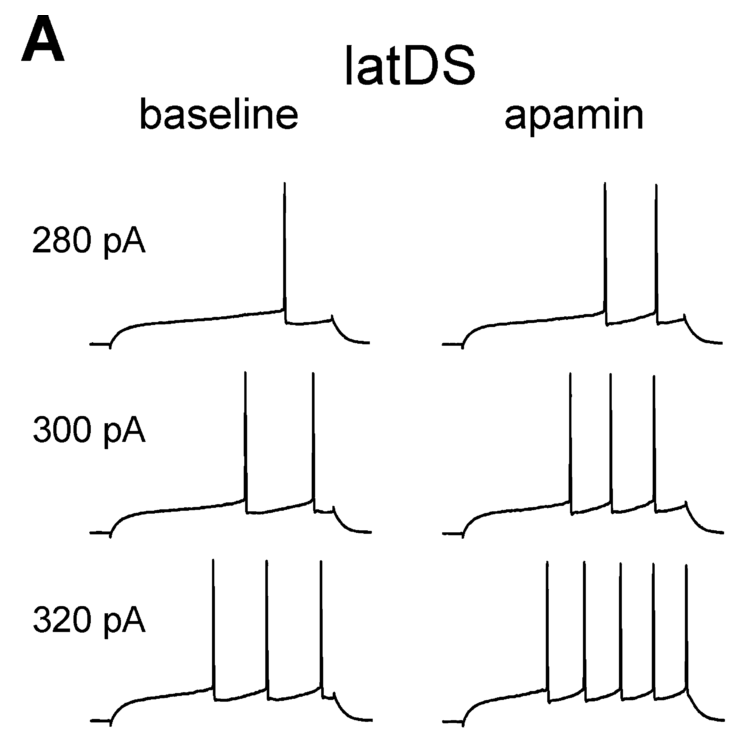

In [4]:
from IPython.display import Image
Image(filename='SK_channel_Hopf_etAl2010.png', width=300)

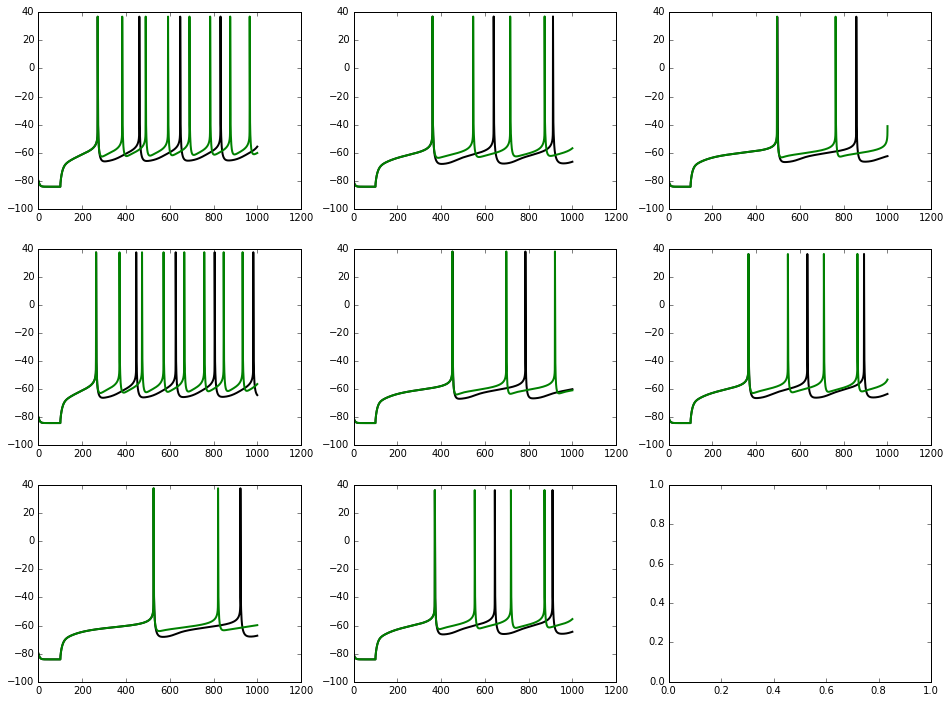

In [5]:
start_simulation(2, block=['control', 'sk'], add=0)

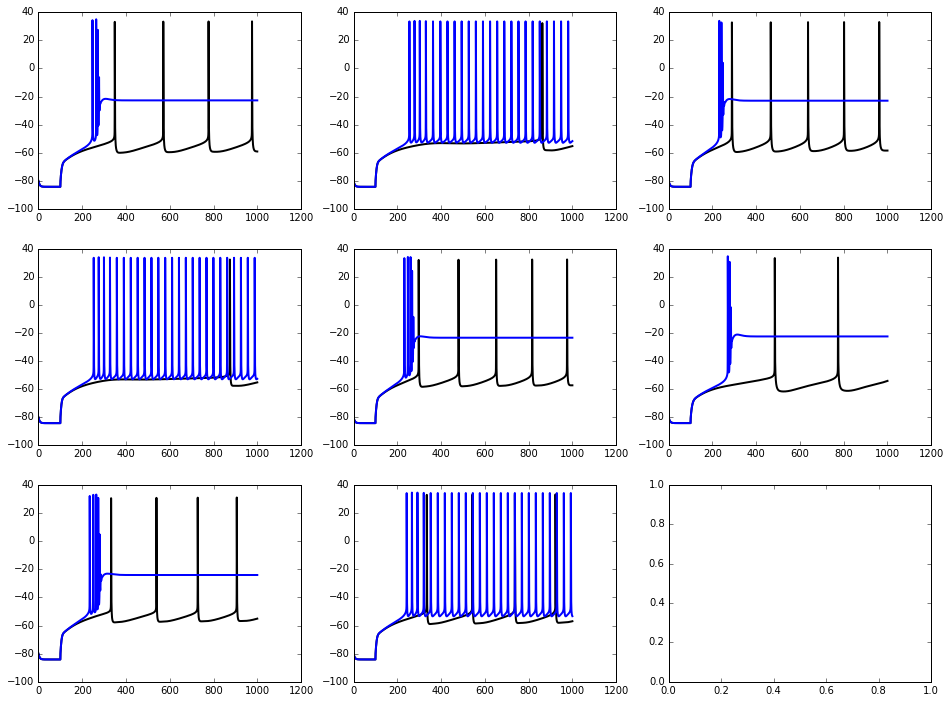

In [6]:
start_simulation(1, block=['control', 'kas'], add=0)

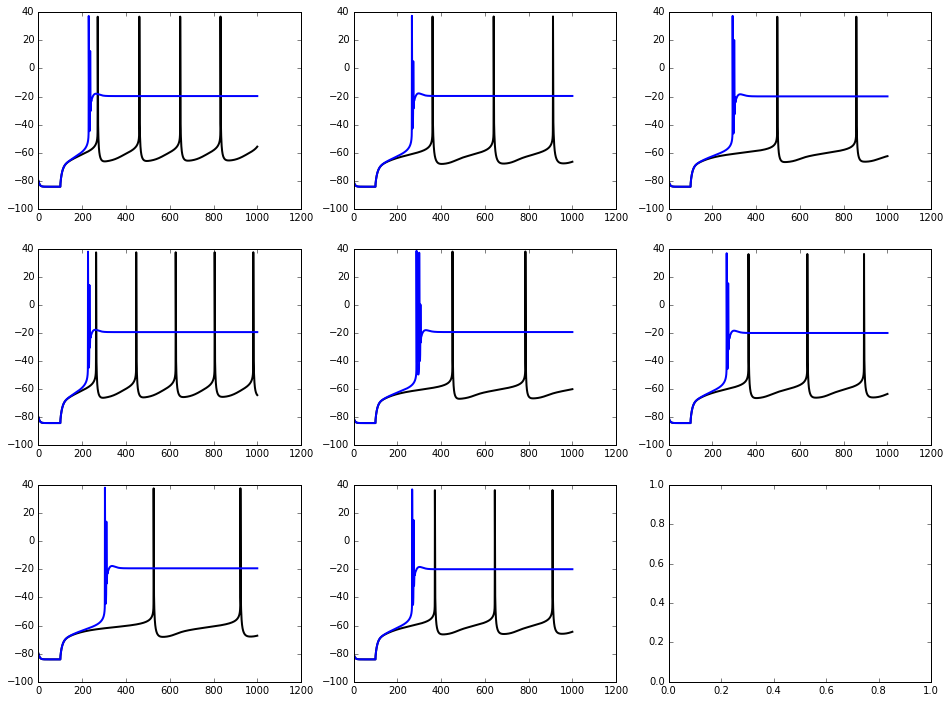

In [7]:
start_simulation(2, block=['control', 'kas'], add=0)

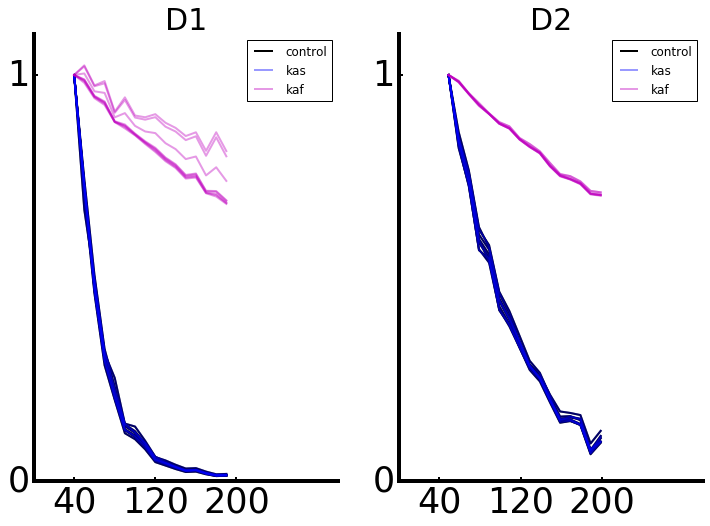

In [8]:
fig,ax  = plt.subplots(1,2, figsize=(12,8) )
start_simulation(1, sim='ca', block=['control', 'kas', 'kaf'], axes=ax[0])
start_simulation(2, sim='ca', block=['control', 'kas', 'kaf'], axes=ax[1])
configure_plot_window(ax)
plt.show() 

-amp: 2.0 [nA] block naf -type D2 -sim ca


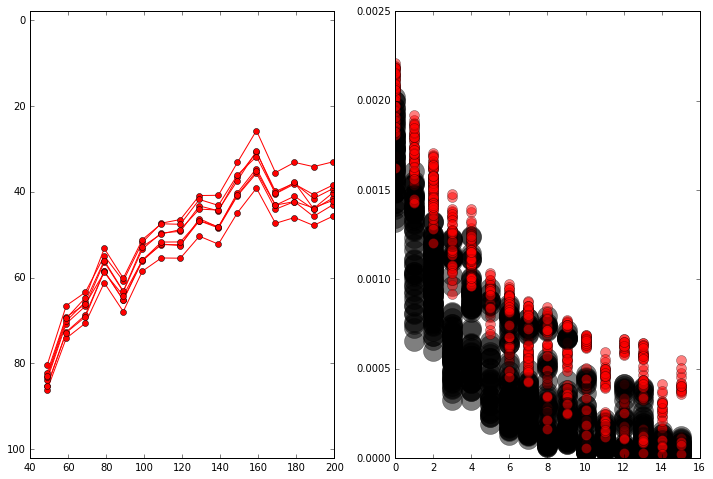

In [16]:
fig,ax  = plt.subplots(1,2, figsize=(12,8) )
start_simulation(2, sim='ca', block=['naf'], axes=ax, lim='30-70')
plt.show()

-amp: 2.0 [nA] block naf -type D1 -sim ca


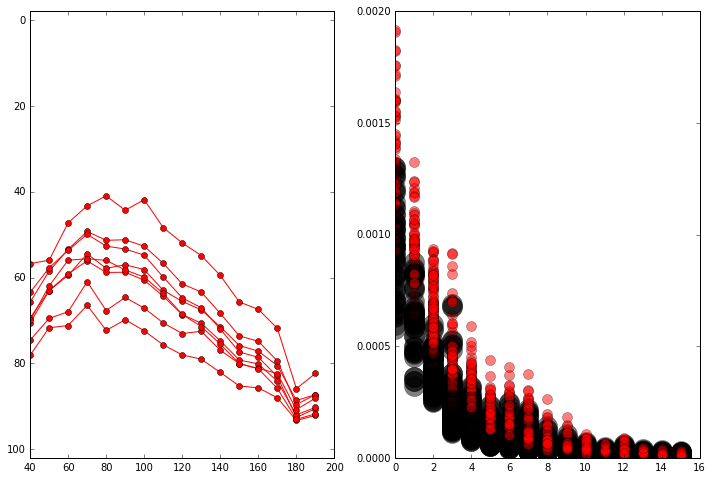

In [17]:
fig,ax  = plt.subplots(1,2, figsize=(12,8) )
start_simulation(1, sim='ca', block=['naf'], axes=ax, lim='30-70')
plt.show()